In [1]:
import numpy as np
import matplotlib.pyplot as plt

from snn.graphs import plot_network
from snn.layers import SCTNLayer
from snn.spiking_network import SpikingNetwork
from snn.spiking_neuron import create_SCTN, BINARY
# from utils.save_model import save_model, load_model


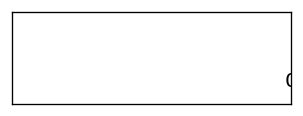

In [2]:
%matplotlib inline
def create_neuron(
        synapses_weights=np.array([0.]),
        leakage_factor=1,
        leakage_period=10,
        theta=0
):
    neuron = create_SCTN()
    neuron.synapses_weights = synapses_weights
    neuron.leakage_factor = leakage_factor
    neuron.leakage_period = leakage_period
    neuron.theta = theta
    neuron.threshold_pulse = 500
    neuron.activation_function = BINARY
    return neuron

clk_freq = int(1.536 * (10 ** 6) * 2)
network = SpikingNetwork(clk_freq=clk_freq)
network.add_layer(SCTNLayer([create_neuron()]))
plot_network(network)
plt.show()

## Plot Decay of membrane

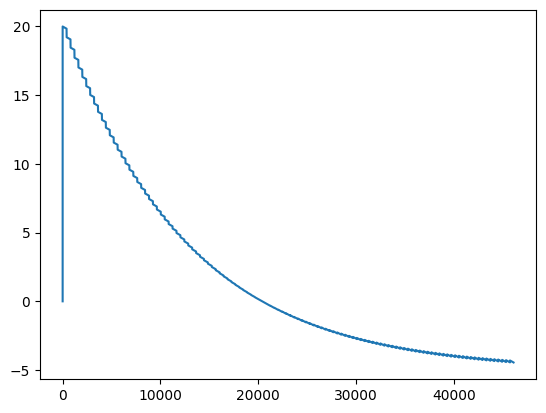

In [18]:
clk_freq = int(1.536 * (10 ** 6) * 2)
network = SpikingNetwork(clk_freq=clk_freq)
neuron = create_neuron(
    synapses_weights=np.array([5.]),
    leakage_factor=5,
    leakage_period=400,
    theta=-1e-4
)
neuron.membrane_sample_max_window = np.zeros(1).astype('float32')

network.add_layer(SCTNLayer([neuron]))
network.log_membrane_potential(0)

time_on_graph = 15e-3
time_on_graph = int(clk_freq * time_on_graph)
spikes = np.zeros(time_on_graph)
spikes[1] = 1
network.input_full_data_spikes(spikes)
plt.plot(network.neurons[0].membrane_potential_graph())

In [8]:
400*.5e-4

0.02

## Add new neurons to network

Plot initialized network.


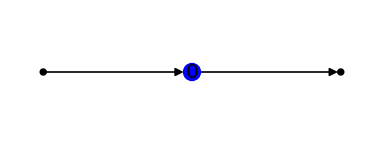

Manually add neuron to layer 0.


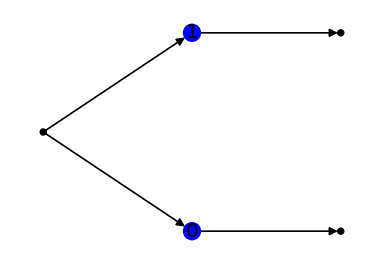

Manually add layer to see if neuron 1 is getting connected.


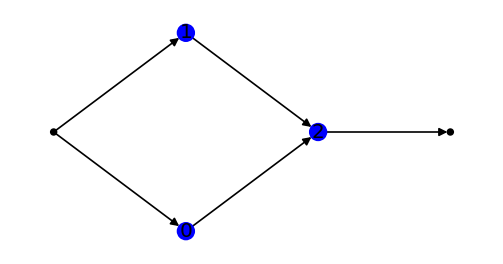

Manually add neuron to layer 1 to see if neuron 1 is getting connected too.


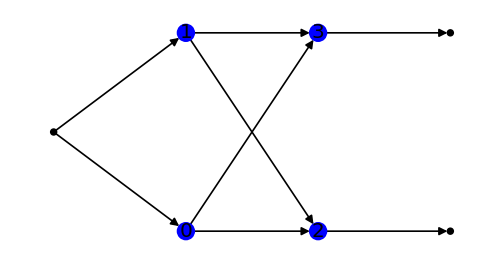

make the 2 last neurons be similar, it should be merged into 1


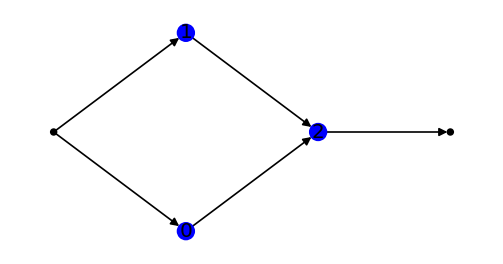

In [4]:
network = SpikingNetwork(clk_freq=clk_freq)

network.add_layer(SCTNLayer([create_neuron()]))
print('Plot initialized network.')
plot_network(network)

network.add_neuron(create_neuron(), 0)
print('Manually add neuron to layer 0.')
plot_network(network)

network.add_layer(SCTNLayer([create_neuron()]))
print('Manually add layer to see if neuron 1 is getting connected.')
plot_network(network)

network.add_neuron(create_neuron(), 1)
print('Manually add neuron to layer 1 to see if neuron 1 is getting connected too.')
plot_network(network)

print('make the 2 last neurons be similar, it should be merged into 1')
network.layers_neurons[0].neurons[0].synapses_weights = np.array([10.])
network.layers_neurons[0].neurons[1].synapses_weights = np.array([15.])
network.layers_neurons[-1].neurons[0].synapses_weights = np.array([1., 2.])
network.layers_neurons[-1].neurons[1].synapses_weights = np.array([1., 2.])
network.remove_irrelevant_neurons()
plot_network(network)


## Save and Load networks

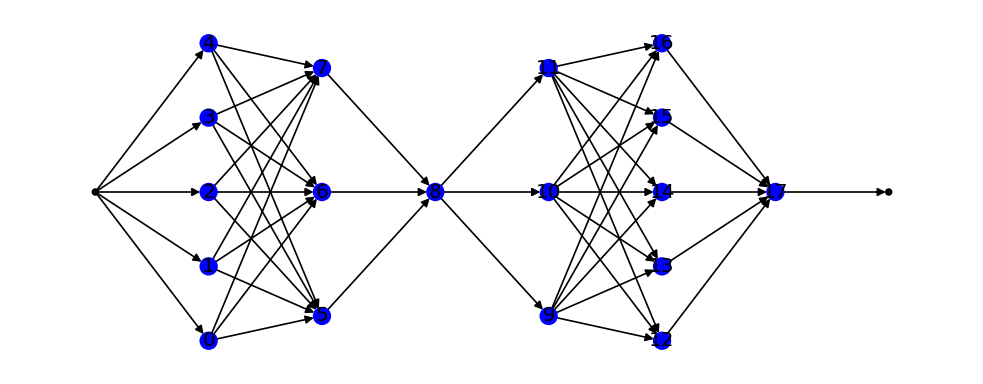

In [4]:
original_network = SpikingNetwork(clk_freq=clk_freq)

def random_params(synapses):
    return dict(
        synapses_weights=np.random.random(synapses) * 300,
        leakage_factor=np.random.randint(5),
        leakage_period=np.random.randint(100),
        theta=-np.random.random()
    )
original_network.add_layer(SCTNLayer([create_neuron(**random_params(1)) for _ in range(5)]))
original_network.add_layer(SCTNLayer([create_neuron(**random_params(5)) for _ in range(3)]))
original_network.add_layer(SCTNLayer([create_neuron(**random_params(3)) for _ in range(1)]))
original_network.add_layer(SCTNLayer([create_neuron(**random_params(1)) for _ in range(3)]))
original_network.add_layer(SCTNLayer([create_neuron(**random_params(3)) for _ in range(5)]))
original_network.add_layer(SCTNLayer([create_neuron(**random_params(5)) for _ in range(1)]))

plot_network(original_network)

In [5]:
from utils import numbaList
from snn.graphs import DirectedEdgeListGraph
import pickle


def save_model(network, path):
    with open(path, 'wb') as handle:
        pickle.dump(network_to_dict(network), handle, protocol=pickle.HIGHEST_PROTOCOL)



def network_to_dict(network):
    return {
        'clk_freq': network.clk_freq,
        'amplitude': network.amplitude,
        'enable_by': list(network.enable_by),
        'spikes_graph': graph_to_dict(network.spikes_graph),
        'layers_neurons': [
            layer_to_list(layer)
            for layer in network.layers_neurons
        ],
    }


def graph_to_dict(graph):
    return {
        'out_edges': list(graph.out_edges),
        'in_edges': list(graph.in_edges),
        'spikes': graph.spikes,
    }


def layer_to_list(layer):
    return [
        neuron_to_dict(n)
        for n in layer.neurons
    ]


def neuron_to_dict(neuron):
    return {
        '_id': neuron._id,
        'label': neuron.label,
        'theta': neuron.theta,
        'reset_to': neuron.reset_to,
        'use_clk_input': neuron.use_clk_input,
        'identity_const': neuron.identity_const,
        'leakage_factor': neuron.leakage_factor,
        'leakage_period': neuron.leakage_period,
        'threshold_pulse': neuron.threshold_pulse,
        'synapses_weights': neuron.synapses_weights,
        'membrane_potential': neuron.membrane_potential,
        'activation_function': neuron.activation_function,
        'membrane_should_reset': neuron.membrane_should_reset,
    }


def load_model(path):
    with open(path, 'rb') as handle:
        network_dictionary = pickle.load(handle)
    network = SpikingNetwork(network_dictionary['clk_freq'])
    network.amplitude = network_dictionary['amplitude']
    network.amplitude = network_dictionary['amplitude']
    for layer_list in network_dictionary['layers_neurons']:
        # first create neurons as templates, adding neurons change their id by connecting them to the network,
        neurons = [create_SCTN() for _ in layer_list]
        network.add_layer(SCTNLayer(neurons))

    network.enable_by = numbaList([np.int32(e) for e in network_dictionary['enable_by']])

    # now replace the connection graph to the saved graph.
    network.spikes_graph = DirectedEdgeListGraph()
    network.spikes_graph.spikes = network_dictionary['spikes_graph']['spikes']
    # return network_dictionary['spikes_graph']['out_edges']
    network.spikes_graph.out_edges = numbaList(network_dictionary['spikes_graph']['out_edges'])
    network.spikes_graph.in_edges = numbaList(network_dictionary['spikes_graph']['in_edges'])

    # now i can change the id to each neuron
    for layer_i, layer in enumerate(network.layers_neurons):
        layer_dict = network_dictionary['layers_neurons'][layer_i]
        for neuron_i, neuron in enumerate(layer.neurons):
            neuron_dict = layer_dict[neuron_i]

            neuron._id = neuron_dict['_id']
            neuron.label = neuron_dict['label']
            neuron.theta = neuron_dict['theta']
            neuron.reset_to = neuron_dict['reset_to']
            neuron.use_clk_input = neuron_dict['use_clk_input']
            neuron.identity_const = neuron_dict['identity_const']
            neuron.leakage_factor = neuron_dict['leakage_factor']
            neuron.leakage_period = neuron_dict['leakage_period']
            neuron.threshold_pulse = neuron_dict['threshold_pulse']
            neuron.synapses_weights = neuron_dict['synapses_weights']
            neuron.membrane_potential = neuron_dict['membrane_potential']
            neuron.activation_function = neuron_dict['activation_function']
            neuron.membrane_should_reset = neuron_dict['membrane_should_reset']
    return network


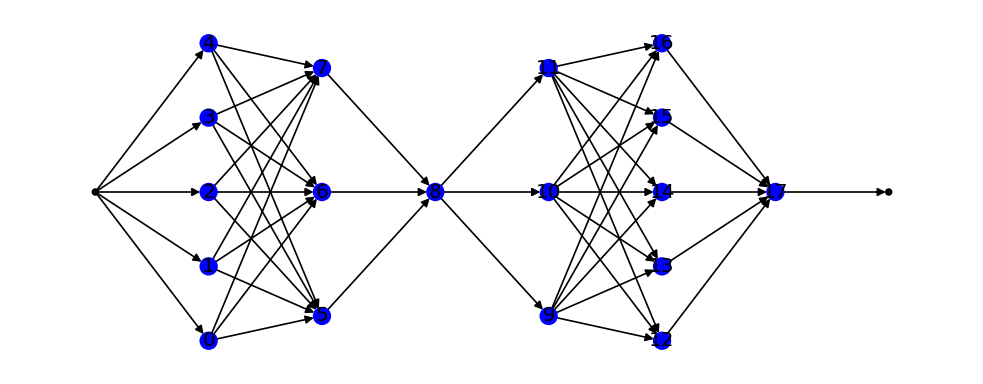

In [6]:
save_model(original_network, path='networks/test.pickle')
loaded_network = load_model(path='networks/test.pickle')
plot_network(loaded_network)

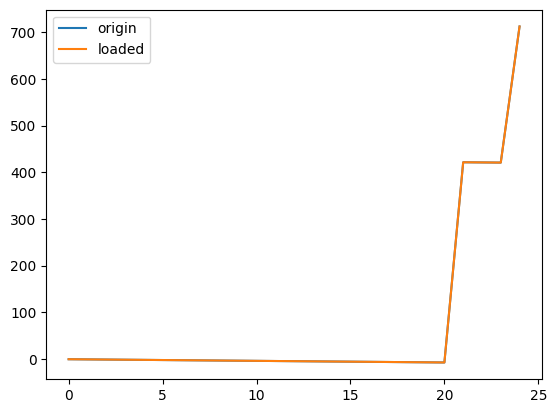

In [8]:
def plot_random_test(network, input_spikes, plt_label):
    network.reset_input()
    network.neurons[-1].membrane_sample_max_window = np.zeros(1).astype('float32')
    network.log_membrane_potential(-1)

    network.input_full_data_spikes(input_spikes)

    plt.plot(network.neurons[-1].membrane_potential_graph(), label=plt_label)

time_on_graph = 10e-3
time_on_graph = int(clk_freq * time_on_graph)
spikes = (np.random.random(time_on_graph) > .5).astype(np.int8)
plot_random_test(original_network, spikes, 'origin')
plot_random_test(loaded_network, spikes, 'loaded')
plt.legend()

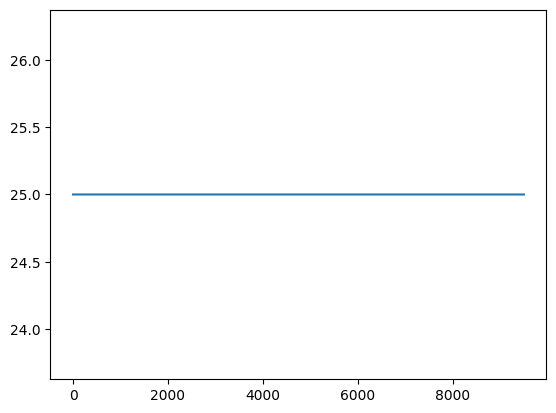

In [6]:
from snn.spiking_neuron import IDENTITY

network = SpikingNetwork(clk_freq=clk_freq)
neuron = create_neuron()
neuron.activation_function = IDENTITY
neuron.identity_const = 3276
network.add_layer(SCTNLayer([neuron]))
network.log_out_spikes(-1)

test_size = 10000
input_spikes = np.zeros(test_size)
network.input_full_data_spikes(input_spikes)

events = neuron.out_spikes()
y_spikes = np.zeros(test_size)
y_spikes[events] = 1
y_spikes = np.convolve(y_spikes, np.ones(500, dtype=int), 'valid')

plt.plot(y_spikes)